In [1]:
# Install required packages
!pip install rasterio geopandas tensorflow scikit-learn matplotlib seaborn tqdm gdown

# Import libraries
import os
import numpy as np
import pandas as pd
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.mask import mask
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Environment setup complete!")


ImportError: Traceback (most recent call last):
  File "C:\Users\arins\anaconda\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [2]:
# Make sure you have a data directory
os.makedirs('data', exist_ok=True)

# Dictionary of files and their Google Drive IDs
files = {
    'Humidity_Uttarakhand_30m.tif': '1dIjajkbiU8IVwKEsMny0rm583g4kWxrf',
    'LULC_MODIS_Uttarakhand_500m.tif': '1Vg_EZ8ENWfo5fLiQzgYjh6hZaue2cdCR',
    'NBR_Uttarakhand_30m.tif': '1l9FUBPycy7EpZ79x9ShUKwDcQ-cFUdom',
    'NDVI_Uttarakhand_30m.tif': '1Vd9ux8_TncGIQTV_BEwCTbaKlo6WsuG5',
    'Population_Uttarakhand_100m.tif': '1WoeP1YUHl0lJqhZVgT_ncWuww4klXGwu',
    'Rainfall_Uttarakhand_30m.tif': '1MIX-3QYZ_c9z9MimxrfU4L8b9re3gxN1',
    'Temperature_Uttarakhand_30m.tif': '1JaU689lWXxQg6fmcgM0PeI-1JfjAw71h',
    'VIIRS_Fire_Uttarakhand_30m.tif': '1rgUIqmTBRhLQzL7O_atKFf0S6ezvMD-c',
    'WindSpeed_Uttarakhand_30m.tif': '1vnEHmEMFWkexGgOox8CAmyVLdD2Gll9D'
}

# Download each file
for fname, file_id in files.items():
    url = f'https://drive.google.com/uc?id={file_id}'
    out_path = os.path.join('data', fname)
    if not os.path.exists(out_path):
        print(f"Downloading {fname}...")
        gdown.download(url, out_path, quiet=False)
    else:
        print(f"{fname} already exists, skipping.")



Humidity_Uttarakhand_30m.tif already exists, skipping.
LULC_MODIS_Uttarakhand_500m.tif already exists, skipping.
NBR_Uttarakhand_30m.tif already exists, skipping.
NDVI_Uttarakhand_30m.tif already exists, skipping.
Population_Uttarakhand_100m.tif already exists, skipping.
Rainfall_Uttarakhand_30m.tif already exists, skipping.
Temperature_Uttarakhand_30m.tif already exists, skipping.
VIIRS_Fire_Uttarakhand_30m.tif already exists, skipping.
WindSpeed_Uttarakhand_30m.tif already exists, skipping.


In [3]:
print("Files in data directory:", os.listdir('data'))

Files in data directory: ['aligned', 'Humidity_Uttarakhand_30m.tif', 'LULC_30m.tif', 'LULC_MODIS_Uttarakhand_500m.tif', 'MODIS_PFT_2023_Uttarakhand_30m.tif', 'NBR_Uttarakhand_30m.tif', 'NDVI_Uttarakhand_30m.tif', 'Population_30m.tif', 'Population_Uttarakhand_100m.tif', 'Rainfall_Uttarakhand_30m.tif', 'Temperature_Uttarakhand_30m.tif', 'Uttarakhand_Aspect_30m.tif', 'Uttarakhand_Elevation_30m.tif', 'Uttarakhand_Hillshade_30m.tif', 'Uttarakhand_Slope_30m.tif', 'VIIRS_Fire_Uttarakhand_30m.tif', 'WindSpeed_Uttarakhand_30m.tif']


In [4]:
file_id = '1WruddoB9Zz5q3FVMYikPfKfbhHZxAWVU'
url = f'https://drive.google.com/uc?id={file_id}'
out_path = os.path.join('data', 'MODIS_PFT_2023_Uttarakhand_30m.tif')

if not os.path.exists(out_path):
    print(f"Downloading MODIS_PFT_2023_Uttarakhand_30m.tif...")
    gdown.download(url, out_path, quiet=False)
else:
    print("Humidity_Uttarakhand_30m.tif already exists, skipping.")


Humidity_Uttarakhand_30m.tif already exists, skipping.


In [5]:
with rasterio.open('data/Humidity_Uttarakhand_30m.tif') as src:
    humidity = src.read(1)
    print("Shape:", humidity.shape)
    print("CRS:", src.crs)
    print("Resolution:", src.res)


Shape: (9551, 12917)
CRS: EPSG:4326
Resolution: (0.00026949458523585647, 0.00026949458523585647)


In [6]:
modis_folder = r"C:\Users\arins\Downloads\DL_FIRE_M-C61_629985"
viirs_snp_folder = r"C:\Users\arins\Downloads\DL_FIRE_SV-C2_629987"
viirs_j1_folder = r"C:\Users\arins\Downloads\DL_FIRE_J1V-C2_629986"

def process_shapefiles(folder_path, label="Dataset"):
    for file in os.listdir(folder_path):
        if file.endswith('.shp'):
            shp_path = os.path.join(folder_path, file)
            print(f"\nProcessing {label} shapefile: {file}")
            try:
                gdf = gpd.read_file(shp_path)
                print(gdf.head())  # Only prints first few rows
            except MemoryError:
                print("MemoryError: File too large to load in memory.")
            except Exception as e:
                print(f"Error reading {file}: {e}")

# Process MODIS, VIIRS-Suomi, and VIIRS-J1 folders
process_shapefiles(modis_folder, label="MODIS")
process_shapefiles(viirs_snp_folder, label="VIIRS-Suomi")
process_shapefiles(viirs_j1_folder, label="VIIRS-J1")



Processing MODIS shapefile: fire_archive_M-C61_629985.shp
   LATITUDE  LONGITUDE  BRIGHTNESS  SCAN  TRACK   ACQ_DATE ACQ_TIME SATELLITE  \
0   30.0915    79.5024       304.5   1.2    1.1 2016-01-01     0517     Terra   
1   31.3276    77.0032       305.0   1.8    1.3 2016-01-01     0517     Terra   
2   29.8945    80.4499       325.8   1.1    1.1 2016-01-01     0518     Terra   
3   29.9037    80.4531       344.4   1.1    1.1 2016-01-01     0518     Terra   
4   27.2507    84.2995       317.8   1.1    1.0 2016-01-01     0518     Terra   

  INSTRUMENT  CONFIDENCE VERSION  BRIGHT_T31   FRP DAYNIGHT  TYPE  \
0      MODIS          58    6.03       285.8   8.7        D     0   
1      MODIS          49    6.03       292.2  16.1        D     0   
2      MODIS          84    6.03       290.4  27.9        D     0   
3      MODIS          94    6.03       289.8  60.2        D     0   
4      MODIS          78    6.03       296.0  14.3        D     0   

                  geometry  
0  POINT (

In [7]:
print("Files in data directory:", os.listdir('data'))

Files in data directory: ['aligned', 'Humidity_Uttarakhand_30m.tif', 'LULC_30m.tif', 'LULC_MODIS_Uttarakhand_500m.tif', 'MODIS_PFT_2023_Uttarakhand_30m.tif', 'NBR_Uttarakhand_30m.tif', 'NDVI_Uttarakhand_30m.tif', 'Population_30m.tif', 'Population_Uttarakhand_100m.tif', 'Rainfall_Uttarakhand_30m.tif', 'Temperature_Uttarakhand_30m.tif', 'Uttarakhand_Aspect_30m.tif', 'Uttarakhand_Elevation_30m.tif', 'Uttarakhand_Hillshade_30m.tif', 'Uttarakhand_Slope_30m.tif', 'VIIRS_Fire_Uttarakhand_30m.tif', 'WindSpeed_Uttarakhand_30m.tif']


In [8]:
# Dictionary of file IDs and output filenames
file_dict = {
    'Uttarakhand_Elevation_30m.tif': '1eek_QQxkxQ8Ner2gG_cfZkFwz6nOU1Bk',
    'Uttarakhand_Slope_30m.tif': '1MyeCqOwCjByNYtkbdLHV2yaCup9H-mJo',
    'Uttarakhand_Aspect_30m.tif': '1qxIrde7H2O2b4P7uRcENbtpreNrr0DcF',
    'Uttarakhand_Hillshade_30m.tif': '1HPYjg2cCtcC5FRq6xKxW4lUNEWBHzqBZ'
}

# Make sure the 'data' directory exists
os.makedirs('data', exist_ok=True)

for filename, file_id in file_dict.items():
    url = f'https://drive.google.com/uc?id={file_id}'
    out_path = os.path.join('data', filename)
    if not os.path.exists(out_path):
        print(f"Downloading {filename}...")
        gdown.download(url, out_path, quiet=False)
    else:
        print(f"{filename} already exists, skipping.")


Uttarakhand_Elevation_30m.tif already exists, skipping.
Uttarakhand_Slope_30m.tif already exists, skipping.
Uttarakhand_Aspect_30m.tif already exists, skipping.
Uttarakhand_Hillshade_30m.tif already exists, skipping.


In [9]:
print("Files in data directory:", os.listdir('data'))

Files in data directory: ['aligned', 'Humidity_Uttarakhand_30m.tif', 'LULC_30m.tif', 'LULC_MODIS_Uttarakhand_500m.tif', 'MODIS_PFT_2023_Uttarakhand_30m.tif', 'NBR_Uttarakhand_30m.tif', 'NDVI_Uttarakhand_30m.tif', 'Population_30m.tif', 'Population_Uttarakhand_100m.tif', 'Rainfall_Uttarakhand_30m.tif', 'Temperature_Uttarakhand_30m.tif', 'Uttarakhand_Aspect_30m.tif', 'Uttarakhand_Elevation_30m.tif', 'Uttarakhand_Hillshade_30m.tif', 'Uttarakhand_Slope_30m.tif', 'VIIRS_Fire_Uttarakhand_30m.tif', 'WindSpeed_Uttarakhand_30m.tif']


In [10]:
# Print files in each folder
print("Files in MODIS folder:", os.listdir(modis_folder))
print("Files in VIIRS-Suomi folder:", os.listdir(viirs_snp_folder))
print("Files in VIIRS-J1 folder:", os.listdir(viirs_j1_folder))


Files in MODIS folder: ['fire_archive_M-C61_629985.cpg', 'fire_archive_M-C61_629985.dbf', 'fire_archive_M-C61_629985.prj', 'fire_archive_M-C61_629985.shp', 'fire_archive_M-C61_629985.shx', 'Readme.txt']
Files in VIIRS-Suomi folder: ['fire_archive_SV-C2_629987.cpg', 'fire_archive_SV-C2_629987.dbf', 'fire_archive_SV-C2_629987.prj', 'fire_archive_SV-C2_629987.shp', 'fire_archive_SV-C2_629987.shx', 'Readme.txt']
Files in VIIRS-J1 folder: ['fire_archive_J1V-C2_629986.cpg', 'fire_archive_J1V-C2_629986.dbf', 'fire_archive_J1V-C2_629986.prj', 'fire_archive_J1V-C2_629986.shp', 'fire_archive_J1V-C2_629986.shx', 'Readme.txt']


# DATA PREPROCESSING

1) Prepare uniform 30m resolution rasters aligned to a common grid :
   Resample LULC (500m → 30m)
   Resample Population (100m → 30m)
2) Stack All Rasters : Align all rasters to a common grid (extent, CRS, resolution).
   



In [2]:
import rasterio
from rasterio.enums import Resampling

def resample_raster(src_path, ref_path, dst_path, resampling=Resampling.bilinear):
    with rasterio.open(ref_path) as ref:
        ref_shape = (ref.height, ref.width)
        ref_transform = ref.transform
        ref_crs = ref.crs
    with rasterio.open(src_path) as src:
        data = src.read(
            out_shape=(src.count, ref_shape[0], ref_shape[1]),
            resampling=resampling
        )
        profile = src.profile
        profile.update({
            'height': ref_shape[0],
            'width': ref_shape[1],
            'transform': ref_transform,
            'crs': ref_crs
        })
        with rasterio.open(dst_path, 'w', **profile) as dst:
            dst.write(data)


In [3]:
from rasterio.mask import mask
import geopandas as gpd

def mask_raster(raster_path, shapefile_path, output_path):
    shapes = gpd.read_file(shapefile_path)
    with rasterio.open(raster_path) as src:
        out_image, out_transform = mask(src, shapes.geometry, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)


Align all features (raster layers) to a common 30m grid and stack them for model input.

In [8]:
# import numpy as np
# feature_paths = [
#     'NDVI_Uttarakhand_30m.tif',
#     'NBR_Uttarakhand_30m.tif',
#     'MODIS_PFT_2023_Uttarakhand_30m.tif',
#     'Temperature_Uttarakhand_30m.tif',
#     'Humidity_Uttarakhand_30m.tif',
#     'WindSpeed_Uttarakhand_30m.tif',
#     'Rainfall_Uttarakhand_30m.tif',
#     'Population_Uttarakhand_100m.tif',
#     'Uttarakhand_Elevation_30m.tif',
#     'Uttarakhand_Slope_30m.tif',
#     'Uttarakhand_Aspect_30m.tif'
#     # Add or remove files as needed for your use-case
# ]

# def stack_features(feature_paths):
#     arrays = []
#     for path in feature_paths:
#         with rasterio.open(path) as src:
#             arrays.append(src.read(1))
#     return np.stack(arrays, axis=-1)  # shape: (height, width, num_features)


In [9]:
# from sklearn.preprocessing import StandardScaler

# X = stack_features(feature_paths)  # shape: (height, width, num_features)
# scaler = StandardScaler()
#  X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)


RasterioIOError: NDVI_Uttarakhand_30m.tif: No such file or directory

# VISUALISATION

In [57]:
!pip install rasterio matplotlib


Processing MODIS shapefile: fire_archive_M-C61_629985.shp
   LATITUDE  LONGITUDE  BRIGHTNESS  SCAN  TRACK   ACQ_DATE ACQ_TIME SATELLITE  \
0   30.0915    79.5024       304.5   1.2    1.1 2016-01-01     0517     Terra   
1   31.3276    77.0032       305.0   1.8    1.3 2016-01-01     0517     Terra   
2   29.8945    80.4499       325.8   1.1    1.1 2016-01-01     0518     Terra   
3   29.9037    80.4531       344.4   1.1    1.1 2016-01-01     0518     Terra   
4   27.2507    84.2995       317.8   1.1    1.0 2016-01-01     0518     Terra   

  INSTRUMENT  CONFIDENCE VERSION  BRIGHT_T31   FRP DAYNIGHT  TYPE  \
0      MODIS          58    6.03       285.8   8.7        D     0   
1      MODIS          49    6.03       292.2  16.1        D     0   
2      MODIS          84    6.03       290.4  27.9        D     0   
3      MODIS          94    6.03       289.8  60.2        D     0   
4      MODIS          78    6.03       296.0  14.3        D     0   

                  geometry  
0  POINT (

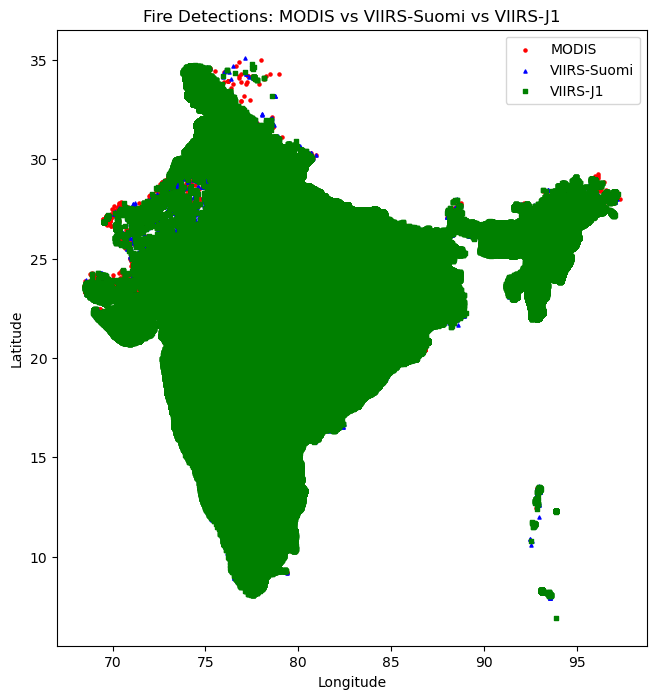

In [13]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt

# Update these folder paths if needed
modis_folder = r"C:\Users\arins\Downloads\DL_FIRE_M-C61_629985"
viirs_snp_folder = r"C:\Users\arins\Downloads\DL_FIRE_SV-C2_629987"
viirs_j1_folder = r"C:\Users\arins\Downloads\DL_FIRE_J1V-C2_629986"

def get_shapefile_path(folder_path):
    """Return the full path to the first .shp file in the folder."""
    for file in os.listdir(folder_path):
        if file.endswith('.shp'):
            return os.path.join(folder_path, file)
    return None

def process_shapefile(shp_path, label="Dataset"):
    """Read a shapefile and print the first few rows."""
    if shp_path is None:
        print(f"No shapefile found for {label}.")
        return None
    print(f"\nProcessing {label} shapefile: {os.path.basename(shp_path)}")
    try:
        gdf = gpd.read_file(shp_path)
        print(gdf.head())
        return gdf
    except MemoryError:
        print("MemoryError: File too large to load in memory.")
    except Exception as e:
        print(f"Error reading {shp_path}: {e}")
    return None

# Get shapefile paths
modis_shp = get_shapefile_path(modis_folder)
viirs_snp_shp = get_shapefile_path(viirs_snp_folder)
viirs_j1_shp = get_shapefile_path(viirs_j1_folder)

# Process and load GeoDataFrames
modis_gdf = process_shapefile(modis_shp, label="MODIS")
viirs_snp_gdf = process_shapefile(viirs_snp_shp, label="VIIRS-Suomi")
viirs_j1_gdf = process_shapefile(viirs_j1_shp, label="VIIRS-J1")

# Visualization if all datasets loaded
if all([modis_gdf is not None, viirs_snp_gdf is not None, viirs_j1_gdf is not None]):
    fig, ax = plt.subplots(figsize=(12, 8))
    modis_gdf.plot(ax=ax, marker='o', color='red', markersize=5, label='MODIS')
    viirs_snp_gdf.plot(ax=ax, marker='^', color='blue', markersize=5, label='VIIRS-Suomi')
    viirs_j1_gdf.plot(ax=ax, marker='s', color='green', markersize=5, label='VIIRS-J1')
    plt.legend()
    plt.title('Fire Detections: MODIS vs VIIRS-Suomi vs VIIRS-J1')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
else:
    print("One or more datasets could not be loaded. Visualization skipped.")



In [12]:
import os
print(os.getcwd())
print(os.listdir('.'))


C:\Users\arins
['-1.14-windows.xml', '.anaconda', '.android', '.arduinoIDE', '.bash_history', '.cache', '.conda', '.condarc', '.config', '.continuum', '.cursor', '.docker', '.gitconfig', '.ipynb_checkpoints', '.ipython', '.jupyter', '.lesshst', '.matplotlib', '.ms-ad', '.node_repl_history', '.vscode', '.vscode-cli', '220107016.ipynb', '220107016_Clean_D6.ipynb', '220107016_tut7.ipynb', 'agro', 'Amex Hack', 'anaconda', 'anaconda3', 'AppData', 'Application Data', 'backend', 'C LANGUAGE', 'C++', 'CF', 'code prac', 'Cookies', 'Customer-Sales-Data-Analysis', 'data', 'Documents', 'Downloads', 'Favorites', 'feature_stack.tif', 'frontend-assignment', 'gcc', 'git_demo', 'homeprices.csv', 'ISRO_Data_processing-Copy1.ipynb', 'ISRO_Data_processing.ipynb', 'ISRO_Feature_eng.ipynb', 'Links', 'Local Settings', 'LULC_30m.tif', 'ML', 'Music', 'My Documents', 'my-nextjs-app', 'my-project', 'MyNew JN folder', 'netflix_sql_project', 'NetHood', 'News-Sentiment-Analysis', 'node_modules', 'NTUSER.DAT', 'ntus

MODIS Uttarakhand fire points: 24446
VIIRS-Suomi Uttarakhand fire points: 182340
VIIRS-J1 Uttarakhand fire points: 131430


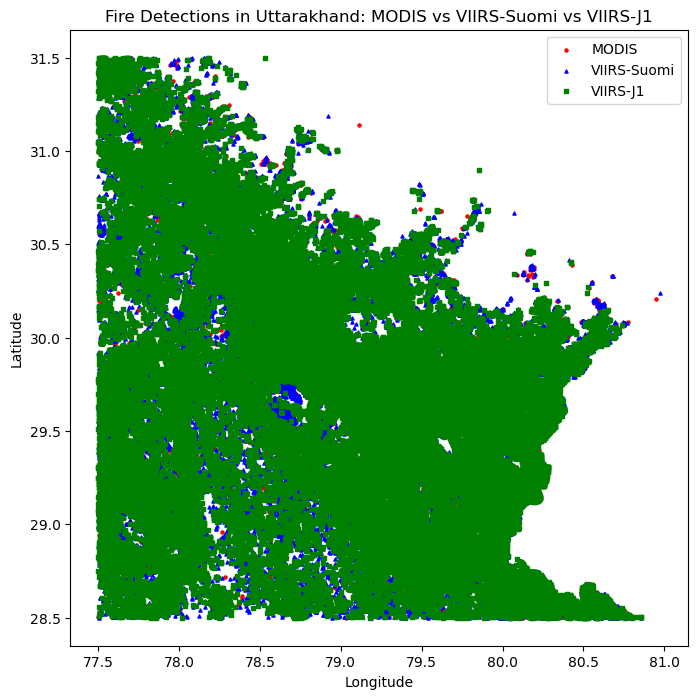

In [15]:
import os
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt

# === UPDATE THESE PATHS TO WHERE YOUR DATA FOLDERS ACTUALLY ARE ===
modis_folder = r"C:\Users\arins\Downloads\DL_FIRE_M-C61_629985"
viirs_snp_folder = r"C:\Users\arins\Downloads\DL_FIRE_SV-C2_629987"
viirs_j1_folder = r"C:\Users\arins\Downloads\DL_FIRE_J1V-C2_629986"

def get_shapefile_path(folder_path):
    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        return None
    for file in os.listdir(folder_path):
        if file.endswith('.shp'):
            return os.path.join(folder_path, file)
    print(f"No shapefile found in: {folder_path}")
    return None

# Load shapefiles
modis_shp = get_shapefile_path(modis_folder)
viirs_snp_shp = get_shapefile_path(viirs_snp_folder)
viirs_j1_shp = get_shapefile_path(viirs_j1_folder)

modis_gdf = gpd.read_file(modis_shp) if modis_shp else None
viirs_snp_gdf = gpd.read_file(viirs_snp_shp) if viirs_snp_shp else None
viirs_j1_gdf = gpd.read_file(viirs_j1_shp) if viirs_j1_shp else None

# Define Uttarakhand bounding box
uttarakhand_bbox = box(77.5, 28.5, 81.0, 31.5)

def filter_by_bbox(gdf, bbox):
    if gdf is None:
        return None
    return gdf[gdf.geometry.within(bbox)]

# Filter for Uttarakhand region
modis_uttarakhand = filter_by_bbox(modis_gdf, uttarakhand_bbox)
viirs_snp_uttarakhand = filter_by_bbox(viirs_snp_gdf, uttarakhand_bbox)
viirs_j1_uttarakhand = filter_by_bbox(viirs_j1_gdf, uttarakhand_bbox)

# Print number of points in each filtered dataset
print("MODIS Uttarakhand fire points:", len(modis_uttarakhand) if modis_uttarakhand is not None else 0)
print("VIIRS-Suomi Uttarakhand fire points:", len(viirs_snp_uttarakhand) if viirs_snp_uttarakhand is not None else 0)
print("VIIRS-J1 Uttarakhand fire points:", len(viirs_j1_uttarakhand) if viirs_j1_uttarakhand is not None else 0)

# Plot filtered points
if all([modis_uttarakhand is not None, viirs_snp_uttarakhand is not None, viirs_j1_uttarakhand is not None]):
    fig, ax = plt.subplots(figsize=(10, 8))
    modis_uttarakhand.plot(ax=ax, marker='o', color='red', markersize=5, label='MODIS')
    viirs_snp_uttarakhand.plot(ax=ax, marker='^', color='blue', markersize=5, label='VIIRS-Suomi')
    viirs_j1_uttarakhand.plot(ax=ax, marker='s', color='green', markersize=5, label='VIIRS-J1')
    plt.legend()
    plt.title('Fire Detections in Uttarakhand: MODIS vs VIIRS-Suomi vs VIIRS-J1')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
else:
    print("One or more Uttarakhand datasets could not be loaded or filtered.")


<Figure size 800x600 with 0 Axes>

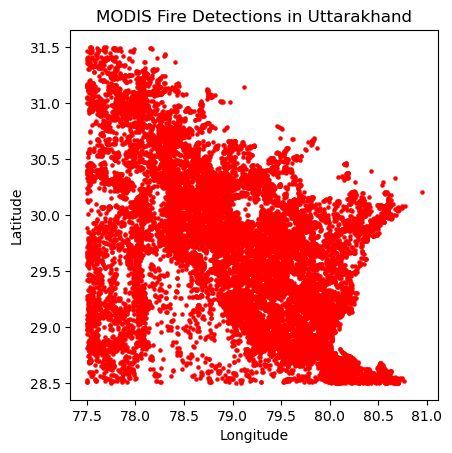

<Figure size 800x600 with 0 Axes>

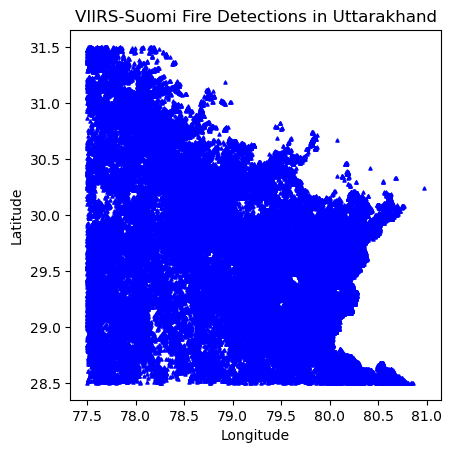

<Figure size 800x600 with 0 Axes>

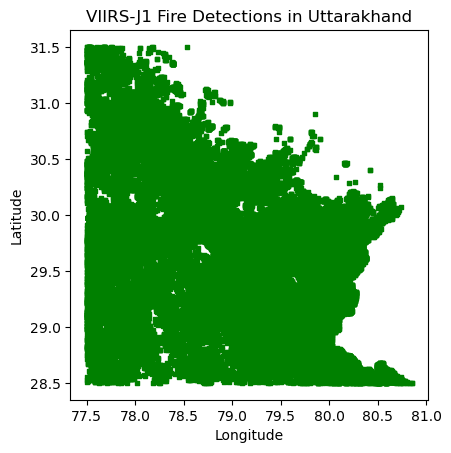

MODIS fire points in Uttarakhand: 24446
VIIRS-Suomi fire points in Uttarakhand: 182340
VIIRS-J1 fire points in Uttarakhand: 131430


In [16]:
import os
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt

# Correct folder paths
modis_folder = r"C:\Users\arins\Downloads\DL_FIRE_M-C61_629985"
viirs_snp_folder = r"C:\Users\arins\Downloads\DL_FIRE_SV-C2_629987"
viirs_j1_folder = r"C:\Users\arins\Downloads\DL_FIRE_J1V-C2_629986"

def get_shapefile_path(folder_path):
    for file in os.listdir(folder_path):
        if file.endswith('.shp'):
            return os.path.join(folder_path, file)
    return None

# Load shapefiles
modis_shp = get_shapefile_path(modis_folder)
viirs_snp_shp = get_shapefile_path(viirs_snp_folder)
viirs_j1_shp = get_shapefile_path(viirs_j1_folder)

modis_gdf = gpd.read_file(modis_shp) if modis_shp else None
viirs_snp_gdf = gpd.read_file(viirs_snp_shp) if viirs_snp_shp else None
viirs_j1_gdf = gpd.read_file(viirs_j1_shp) if viirs_j1_shp else None

# Uttarakhand bounding box
uttarakhand_bbox = box(77.5, 28.5, 81.0, 31.5)

def filter_by_bbox(gdf, bbox):
    if gdf is None:
        return None
    return gdf[gdf.geometry.within(bbox)]

modis_uttarakhand = filter_by_bbox(modis_gdf, uttarakhand_bbox)
viirs_snp_uttarakhand = filter_by_bbox(viirs_snp_gdf, uttarakhand_bbox)
viirs_j1_uttarakhand = filter_by_bbox(viirs_j1_gdf, uttarakhand_bbox)

# Plot separate figures for each dataset
datasets = [
    ("MODIS Fire Detections in Uttarakhand", modis_uttarakhand, 'o', 'red'),
    ("VIIRS-Suomi Fire Detections in Uttarakhand", viirs_snp_uttarakhand, '^', 'blue'),
    ("VIIRS-J1 Fire Detections in Uttarakhand", viirs_j1_uttarakhand, 's', 'green')
]

for title, gdf, marker, color in datasets:
    plt.figure(figsize=(8, 6))
    if gdf is not None and not gdf.empty:
        gdf.plot(marker=marker, color=color, markersize=5)
        plt.title(title)
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
    else:
        plt.text(0.5, 0.5, f'No data for {title}', horizontalalignment='center', verticalalignment='center')
    plt.show()

# Print counts for reference
print(f"MODIS fire points in Uttarakhand: {len(modis_uttarakhand) if modis_uttarakhand is not None else 0}")
print(f"VIIRS-Suomi fire points in Uttarakhand: {len(viirs_snp_uttarakhand) if viirs_snp_uttarakhand is not None else 0}")
print(f"VIIRS-J1 fire points in Uttarakhand: {len(viirs_j1_uttarakhand) if viirs_j1_uttarakhand is not None else 0}")


MODIS high confidence fire points in Uttarakhand: 24446
VIIRS-Suomi high confidence fire points in Uttarakhand: 182340
VIIRS-J1 high confidence fire points in Uttarakhand: 131430


<Figure size 800x600 with 0 Axes>

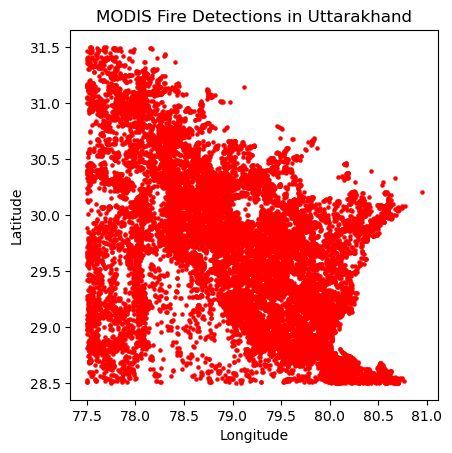

<Figure size 800x600 with 0 Axes>

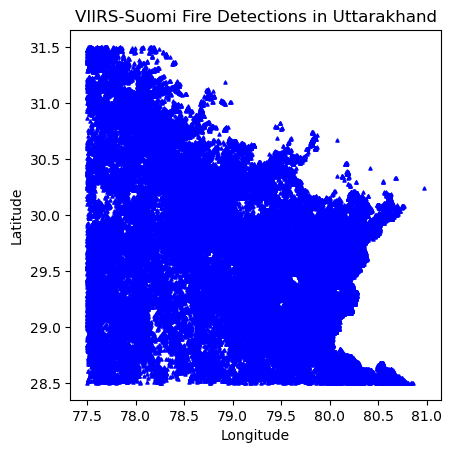

<Figure size 800x600 with 0 Axes>

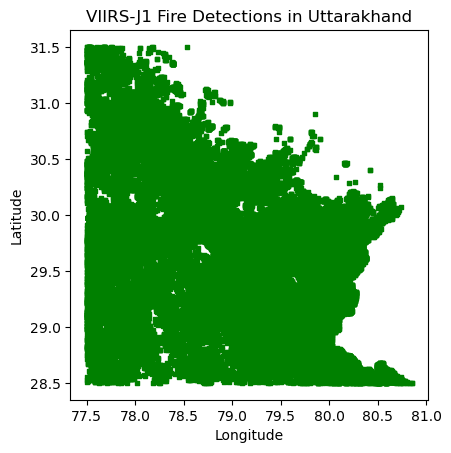

C:\Users\arins\anaconda\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Field ACQ_DATE create as date field, though DateTime requested.
  ogr_write(
C:\Users\arins\anaconda\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Field ACQ_DATE create as date field, though DateTime requested.
  ogr_write(
C:\Users\arins\anaconda\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Field ACQ_DATE create as date field, though DateTime requested.
  ogr_write(


In [17]:
import os
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt

# Update these paths to where your data actually resides
modis_folder = r"C:\Users\arins\Downloads\DL_FIRE_M-C61_629985"
viirs_snp_folder = r"C:\Users\arins\Downloads\DL_FIRE_SV-C2_629987"
viirs_j1_folder = r"C:\Users\arins\Downloads\DL_FIRE_J1V-C2_629986"

def get_shapefile_path(folder_path):
    if not os.path.exists(folder_path):
        print(f"Folder does NOT exist: {folder_path}")
        return None
    for file in os.listdir(folder_path):
        if file.endswith('.shp'):
            return os.path.join(folder_path, file)
    print(f"No .shp file found in: {folder_path}")
    return None

modis_shp = get_shapefile_path(modis_folder)
viirs_snp_shp = get_shapefile_path(viirs_snp_folder)
viirs_j1_shp = get_shapefile_path(viirs_j1_folder)

modis_gdf = gpd.read_file(modis_shp) if modis_shp else None
viirs_snp_gdf = gpd.read_file(viirs_snp_shp) if viirs_snp_shp else None
viirs_j1_gdf = gpd.read_file(viirs_j1_shp) if viirs_j1_shp else None

# Uttarakhand bounding box (approximate)
uttarakhand_bbox = box(77.5, 28.5, 81.0, 31.5)

def filter_by_bbox_and_confidence(gdf, bbox, conf_col='confidence', conf_thresh=75):
    if gdf is None:
        return None
    filtered = gdf[gdf.geometry.within(bbox)]
    if conf_col in filtered.columns:
        filtered = filtered[filtered[conf_col] >= conf_thresh]
    return filtered

modis_uttarakhand = filter_by_bbox_and_confidence(modis_gdf, uttarakhand_bbox)
viirs_snp_uttarakhand = filter_by_bbox_and_confidence(viirs_snp_gdf, uttarakhand_bbox)
viirs_j1_uttarakhand = filter_by_bbox_and_confidence(viirs_j1_gdf, uttarakhand_bbox)

# Print counts for reference
print(f"MODIS high confidence fire points in Uttarakhand: {len(modis_uttarakhand) if modis_uttarakhand is not None else 0}")
print(f"VIIRS-Suomi high confidence fire points in Uttarakhand: {len(viirs_snp_uttarakhand) if viirs_snp_uttarakhand is not None else 0}")
print(f"VIIRS-J1 high confidence fire points in Uttarakhand: {len(viirs_j1_uttarakhand) if viirs_j1_uttarakhand is not None else 0}")

# Plot separate figures for each dataset
datasets = [
    ("MODIS Fire Detections in Uttarakhand", modis_uttarakhand, 'o', 'red'),
    ("VIIRS-Suomi Fire Detections in Uttarakhand", viirs_snp_uttarakhand, '^', 'blue'),
    ("VIIRS-J1 Fire Detections in Uttarakhand", viirs_j1_uttarakhand, 's', 'green')
]

for title, gdf, marker, color in datasets:
    plt.figure(figsize=(8, 6))
    if gdf is not None and not gdf.empty:
        gdf.plot(marker=marker, color=color, markersize=5)
        plt.title(title)
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
    else:
        plt.text(0.5, 0.5, f'No data for {title}', horizontalalignment='center', verticalalignment='center')
    plt.show()

# Optionally, save filtered points for rasterization or further ML processing
output_dir = r"C:\Users\arins\Downloads\uttarakhand_fire_points"
os.makedirs(output_dir, exist_ok=True)
if modis_uttarakhand is not None:
    modis_uttarakhand.to_file(os.path.join(output_dir, "modis_uttarakhand_highconf.shp"))
if viirs_snp_uttarakhand is not None:
    viirs_snp_uttarakhand.to_file(os.path.join(output_dir, "viirs_snp_uttarakhand_highconf.shp"))
if viirs_j1_uttarakhand is not None:
    viirs_j1_uttarakhand.to_file(os.path.join(output_dir, "viirs_j1_uttarakhand_highconf.shp"))


In [18]:
pip install rasterio

Note: you may need to restart the kernel to use updated packages.


In [19]:
import geopandas as gpd
import numpy as np
from rasterio.transform import from_origin
from rasterio.features import rasterize
import rasterio

# Define Uttarakhand bounding box and raster parameters
minx, miny, maxx, maxy = 77.5, 28.5, 81.0, 31.5
pixel_size = 30  # meters

# Approximate meters per degree (at Uttarakhand latitude)
meters_per_deg_x = 111320
meters_per_deg_y = 110540

width = int((maxx - minx) * meters_per_deg_x / pixel_size)
height = int((maxy - miny) * meters_per_deg_y / pixel_size)

# Define raster transform (top-left origin)
transform = from_origin(minx, maxy, pixel_size / meters_per_deg_x, pixel_size / meters_per_deg_y)

def rasterize_points(gdf, transform, width, height, out_path):
    if gdf is None or gdf.empty:
        print("No data to rasterize.")
        return
    shapes = ((geom, 1) for geom in gdf.geometry)
    raster = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype='uint8'
    )
    # Save raster to GeoTIFF
    with rasterio.open(
        out_path,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=1,
        dtype='uint8',
        crs='EPSG:4326',
        transform=transform,
    ) as dst:
        dst.write(raster, 1)
    print(f"Raster saved to {out_path}. Fire pixels: {np.sum(raster)}")

# Example usage for each dataset (update gdf variables as needed)
rasterize_points(modis_uttarakhand, transform, width, height, r"modis_fire_uttarakhand_30m.tif")
rasterize_points(viirs_snp_uttarakhand, transform, width, height, r"viirs_snp_fire_uttarakhand_30m.tif")
rasterize_points(viirs_j1_uttarakhand, transform, width, height, r"viirs_j1_fire_uttarakhand_30m.tif")


Raster saved to modis_fire_uttarakhand_30m.tif. Fire pixels: 24436
Raster saved to viirs_snp_fire_uttarakhand_30m.tif. Fire pixels: 181786
Raster saved to viirs_j1_fire_uttarakhand_30m.tif. Fire pixels: 131143


In [20]:
import os

out_dir = 'data'
os.makedirs(out_dir, exist_ok=True)


In [21]:
rasterize_points(modis_uttarakhand, transform, width, height, os.path.join(out_dir, "modis_fire_uttarakhand_30m.tif"))
rasterize_points(viirs_snp_uttarakhand, transform, width, height, os.path.join(out_dir, "viirs_snp_fire_uttarakhand_30m.tif"))
rasterize_points(viirs_j1_uttarakhand, transform, width, height, os.path.join(out_dir, "viirs_j1_fire_uttarakhand_30m.tif"))


Raster saved to data\modis_fire_uttarakhand_30m.tif. Fire pixels: 24436
Raster saved to data\viirs_snp_fire_uttarakhand_30m.tif. Fire pixels: 181786
Raster saved to data\viirs_j1_fire_uttarakhand_30m.tif. Fire pixels: 131143


In [22]:
print("Files in data directory:", os.listdir('data'))

Files in data directory: ['aligned', 'Humidity_Uttarakhand_30m.tif', 'LULC_30m.tif', 'LULC_MODIS_Uttarakhand_500m.tif', 'modis_fire_uttarakhand_30m.tif', 'MODIS_PFT_2023_Uttarakhand_30m.tif', 'NBR_Uttarakhand_30m.tif', 'NDVI_Uttarakhand_30m.tif', 'Population_30m.tif', 'Population_Uttarakhand_100m.tif', 'Rainfall_Uttarakhand_30m.tif', 'Temperature_Uttarakhand_30m.tif', 'Uttarakhand_Aspect_30m.tif', 'Uttarakhand_Elevation_30m.tif', 'Uttarakhand_Hillshade_30m.tif', 'Uttarakhand_Slope_30m.tif', 'VIIRS_Fire_Uttarakhand_30m.tif', 'viirs_j1_fire_uttarakhand_30m.tif', 'viirs_snp_fire_uttarakhand_30m.tif', 'WindSpeed_Uttarakhand_30m.tif']


Visualizing: Humidity_Uttarakhand_30m.tif


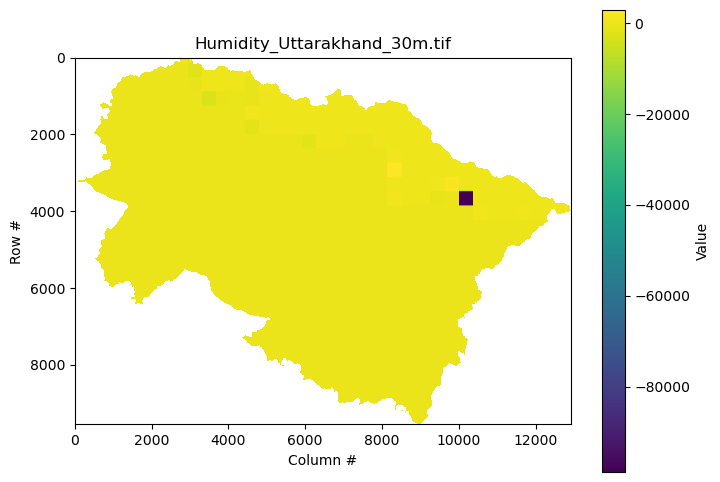

Visualizing: LULC_30m.tif


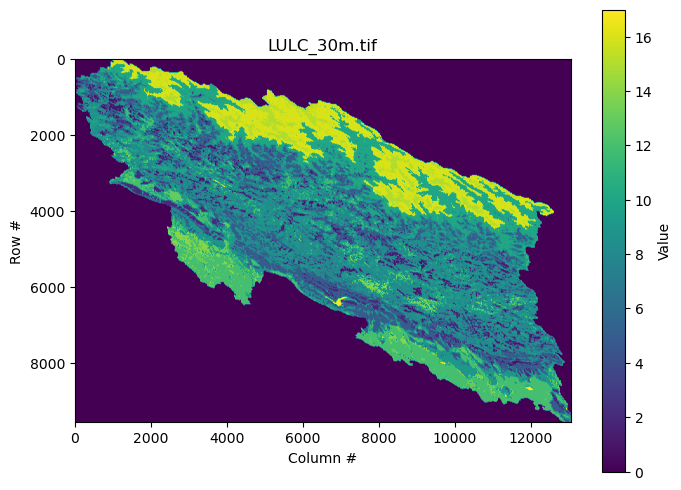

Visualizing: LULC_MODIS_Uttarakhand_500m.tif


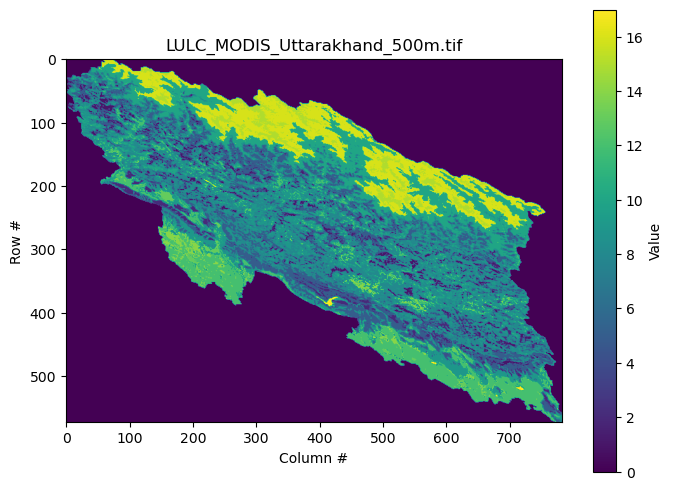

Visualizing: modis_fire_uttarakhand_30m.tif


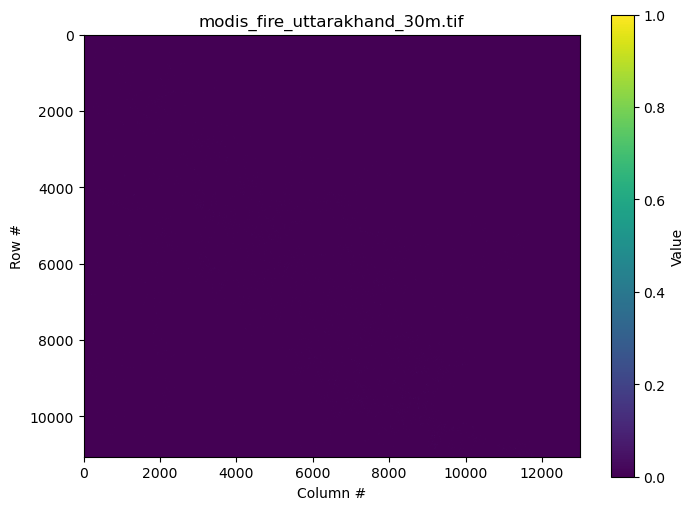

Visualizing: MODIS_PFT_2023_Uttarakhand_30m.tif


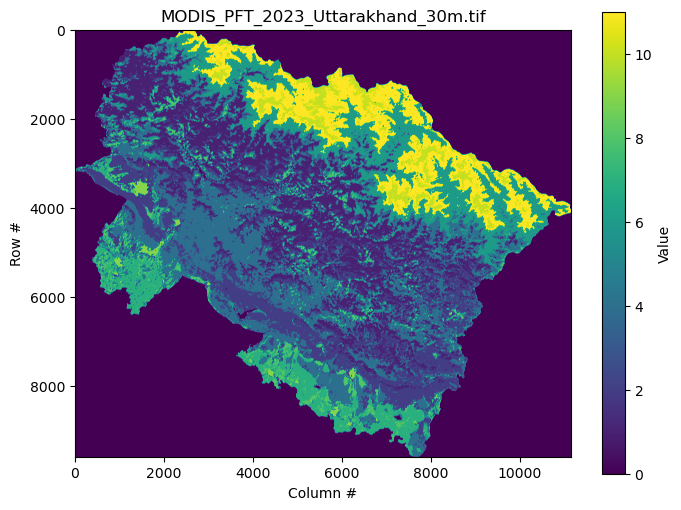

Visualizing: NBR_Uttarakhand_30m.tif


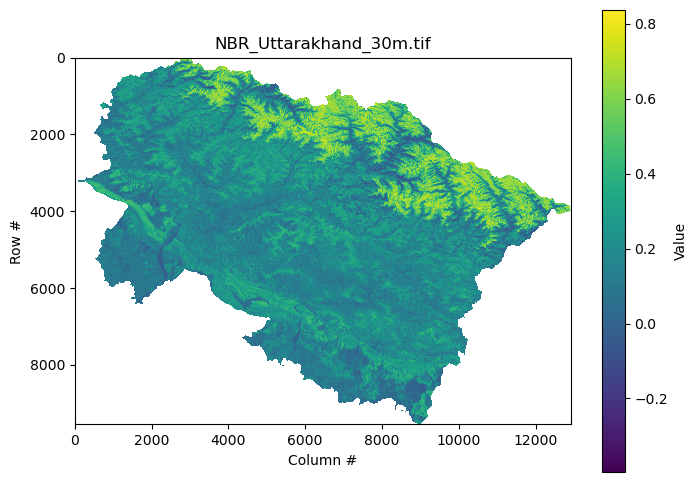

Visualizing: NDVI_Uttarakhand_30m.tif


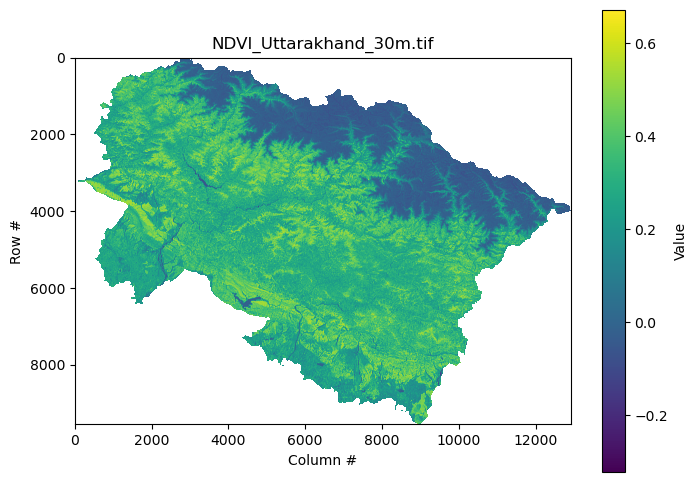

Visualizing: Population_Uttarakhand_100m.tif


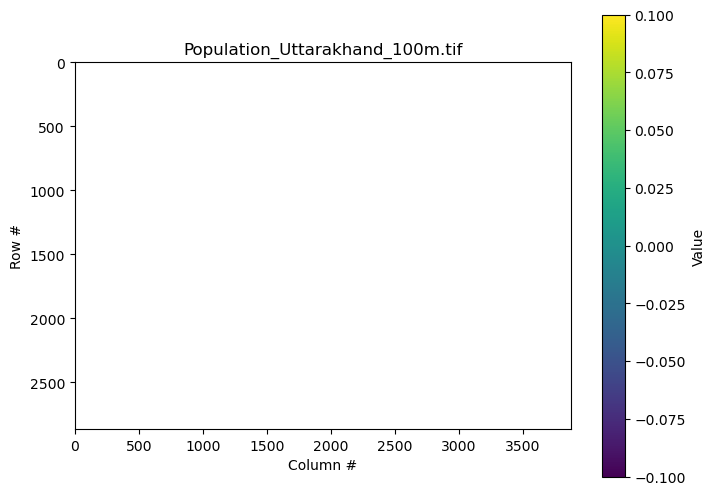

Visualizing: Rainfall_Uttarakhand_30m.tif


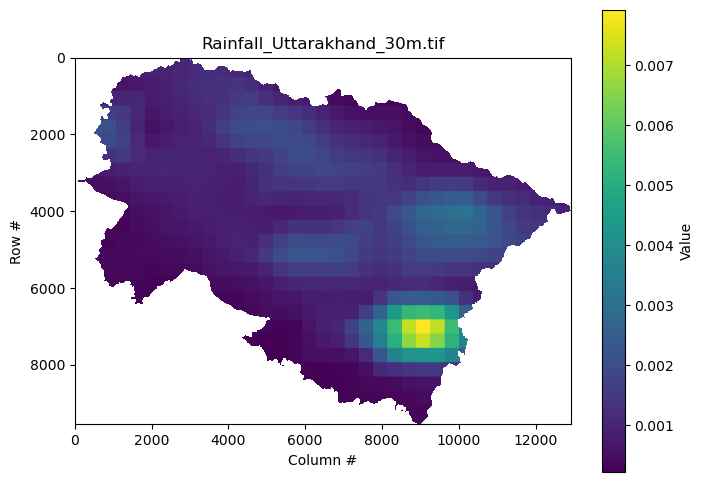

Visualizing: Temperature_Uttarakhand_30m.tif


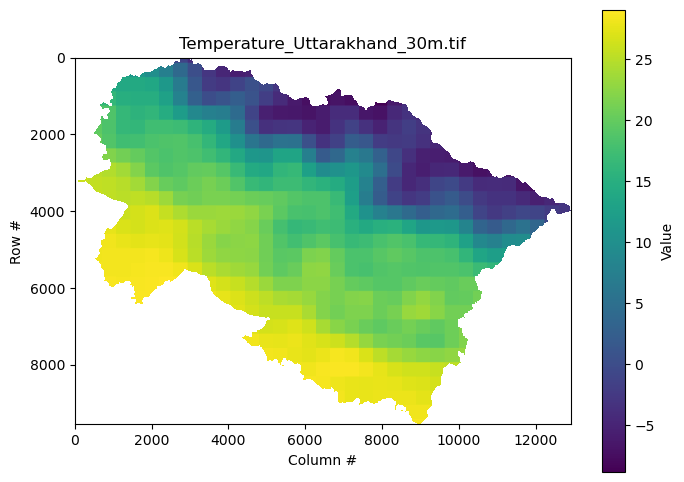

Visualizing: Uttarakhand_Aspect_30m.tif


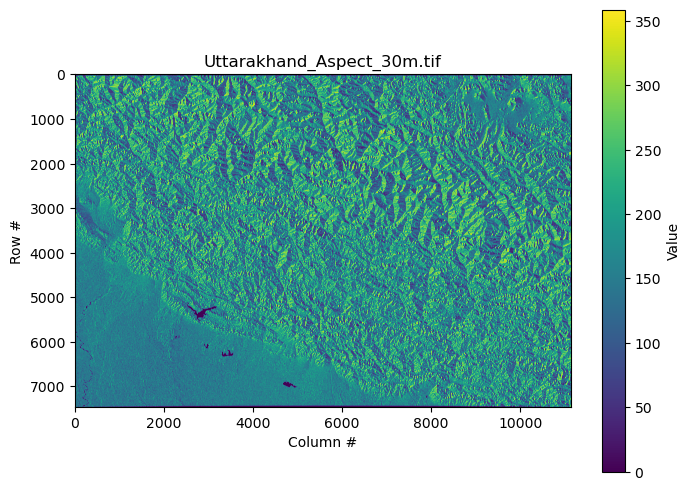

Visualizing: Uttarakhand_Elevation_30m.tif


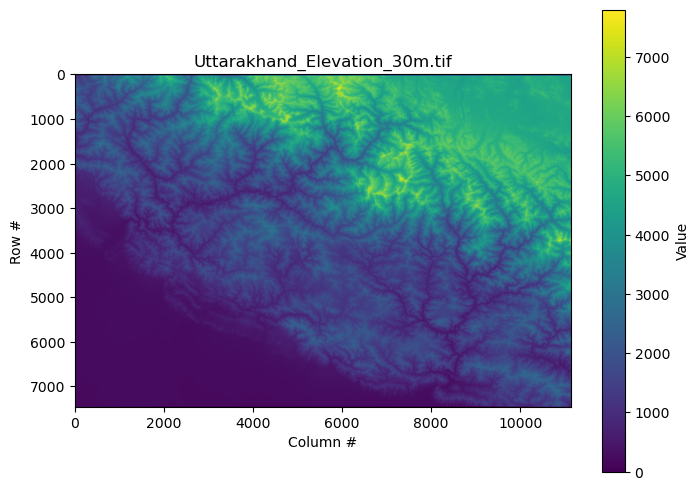

Visualizing: Uttarakhand_Hillshade_30m.tif


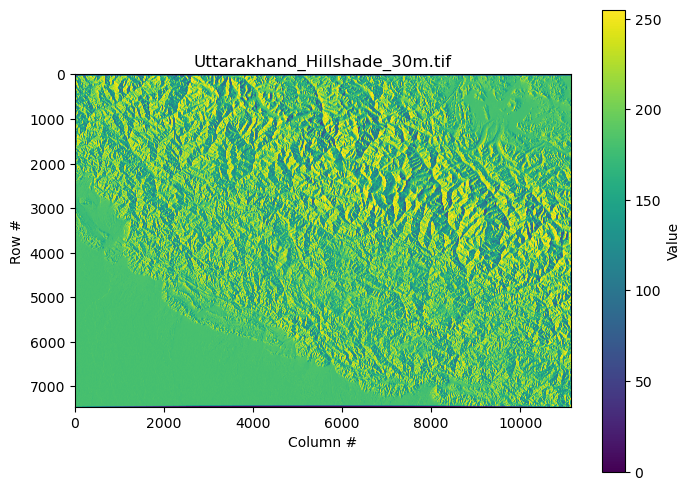

Visualizing: Uttarakhand_Slope_30m.tif


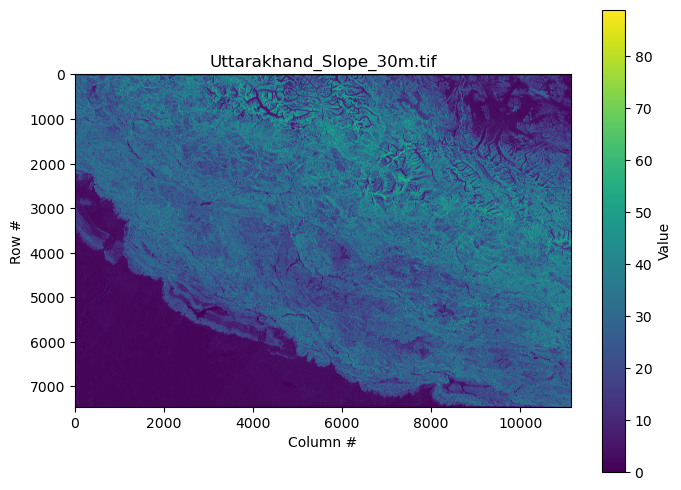

Visualizing: VIIRS_Fire_Uttarakhand_30m.tif


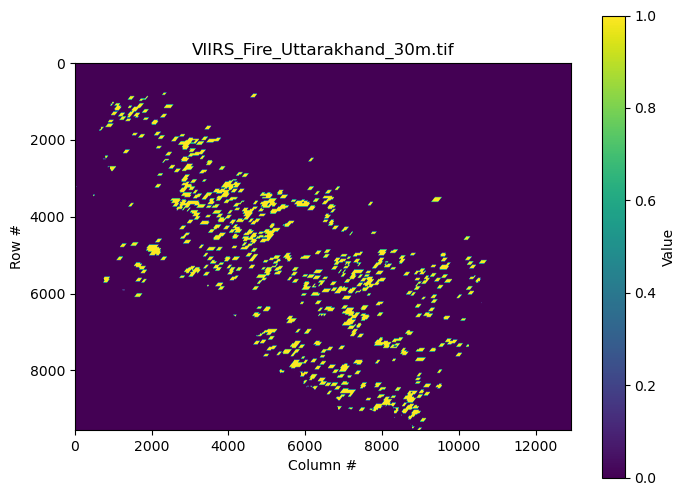

Visualizing: viirs_j1_fire_uttarakhand_30m.tif


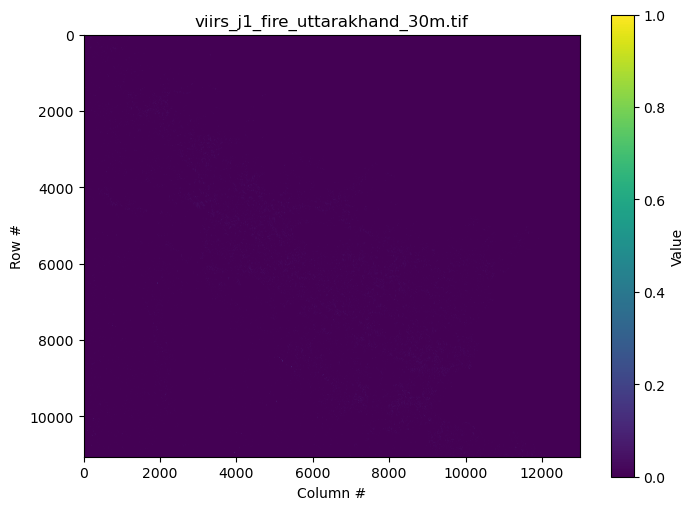

Visualizing: viirs_snp_fire_uttarakhand_30m.tif


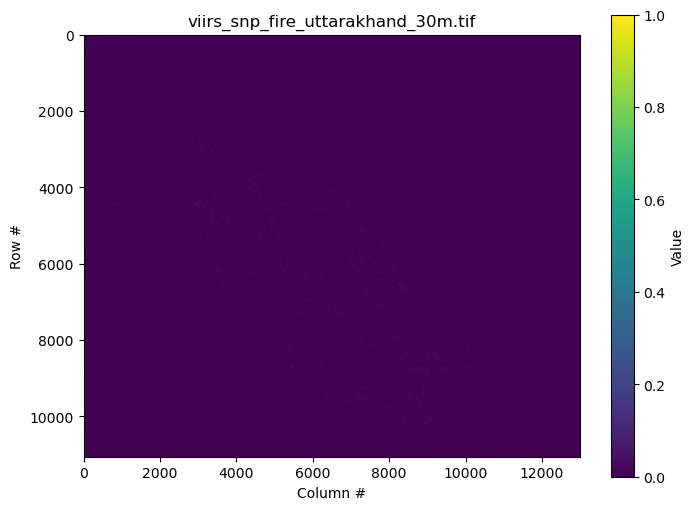

Visualizing: WindSpeed_Uttarakhand_30m.tif


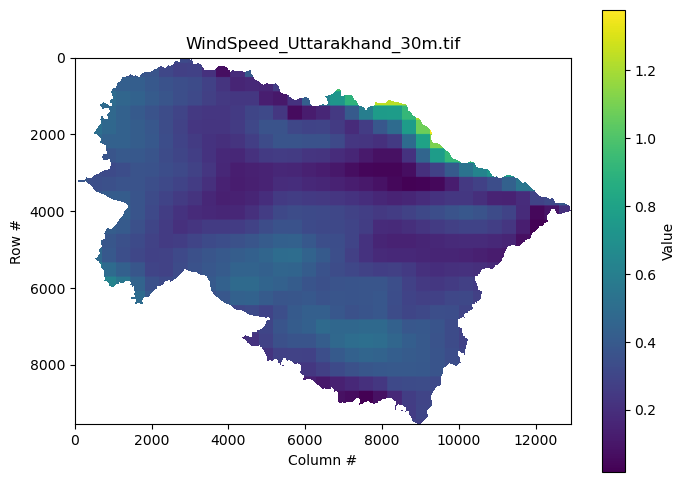

In [1]:
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Directory containing the raster files
data_dir = 'data'

# List all .tif files in the data directory (excluding subdirectories)
raster_files = [f for f in os.listdir(data_dir) if f.endswith('.tif') and os.path.isfile(os.path.join(data_dir, f))]

def plot_raster(file_path, title):
    with rasterio.open(file_path) as src:
        raster_data = src.read(1)
        # Mask no data values for better visualization
        if src.nodata is not None:
            raster_data = np.where(raster_data == src.nodata, np.nan, raster_data)
        plt.figure(figsize=(8, 6))
        plt.imshow(raster_data, cmap='viridis')
        plt.title(title)
        plt.colorbar(label='Value')
        plt.xlabel('Column #')
        plt.ylabel('Row #')
        plt.show()

# Visualize each raster one by one
for raster_file in raster_files:
    file_path = os.path.join(data_dir, raster_file)
    print(f"Visualizing: {raster_file}")
    plot_raster(file_path, raster_file)


# Remove Redundant and Irrelevant Layers
Remove LULC_30m.tif: Since you have both LULC_30m.tif and LULC_MODIS_Uttarakhand_500m.tif, but only one is at 30m resolution (required by your PS), keep the higher-resolution, Uttarakhand-specific LULC. If LULC_30m.tif covers your region at 30m, keep it and remove the MODIS 500m file; otherwise, keep the most relevant one for your study area and resolution.

Remove Population_30m.tif and Population_Uttarakhand_100m.tif: These layers seem to be empty or uniform, and population is not a required feature per your PS.

In [2]:
import os

files_to_remove = [
     # or 'data/LULC_30m.tif' if you prefer the MODIS one
    'data/Population_30m.tif',
    'data/Population_Uttarakhand_100m.tif'
]

for f in files_to_remove:
    if os.path.exists(f):
        os.remove(f)
        print(f"Removed {f}")
    else:
        print(f"{f} not found or already removed.")


data/Population_30m.tif not found or already removed.
Removed data/Population_Uttarakhand_100m.tif


In [3]:
print("Files in data directory:", os.listdir('data'))

Files in data directory: ['aligned', 'fire_target_binary_uttarakhand_30m.png', 'Humidity_Uttarakhand_30m.tif', 'LULC_30m.tif', 'LULC_MODIS_Uttarakhand_500m.tif', 'modis_fire_uttarakhand_30m.tif', 'MODIS_PFT_2023_Uttarakhand_30m.tif', 'NBR_Uttarakhand_30m.tif', 'NDVI_Uttarakhand_30m.tif', 'processed', 'Rainfall_Uttarakhand_30m.tif', 'reprojected', 'Temperature_Uttarakhand_30m.tif', 'Uttarakhand_Aspect_30m.tif', 'Uttarakhand_Elevation_30m.tif', 'Uttarakhand_Hillshade_30m.tif', 'Uttarakhand_Slope_30m.tif', 'VIIRS_Fire_Uttarakhand_30m.tif', 'viirs_j1_fire_uttarakhand_30m.tif', 'viirs_snp_fire_uttarakhand_30m.tif', 'WindSpeed_Uttarakhand_30m.tif']


# Reproject and Align All Rasters
Why: All rasters must have the same CRS, extent, and pixel alignment for stacking and ML input.

How: Use your highest-quality DEM as the reference (e.g., Uttarakhand_Elevation_30m.tif). Reproject and resample all other rasters to match its CRS, bounds, and resolution.

In [4]:
import os
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

data_dir = 'data'
feature_files = [
    'Humidity_Uttarakhand_30m.tif', 
    'LULC_30m.tif', 
    'modis_fire_uttarakhand_30m.tif', 
    'MODIS_PFT_2023_Uttarakhand_30m.tif', 
    'NBR_Uttarakhand_30m.tif', 
    'NDVI_Uttarakhand_30m.tif', 
    'Rainfall_Uttarakhand_30m.tif', 
    'Temperature_Uttarakhand_30m.tif', 
    'Uttarakhand_Aspect_30m.tif', 
    'Uttarakhand_Elevation_30m.tif', 
    'Uttarakhand_Hillshade_30m.tif', 
    'Uttarakhand_Slope_30m.tif', 
    'VIIRS_Fire_Uttarakhand_30m.tif', 
    'viirs_j1_fire_uttarakhand_30m.tif', 
    'viirs_snp_fire_uttarakhand_30m.tif', 
    'WindSpeed_Uttarakhand_30m.tif'
]
target_files = [
    'viirs_snp_fire_uttarakhand_30m.tif', 'viirs_j1_fire_uttarakhand_30m.tif', 'modis_fire_uttarakhand_30m.tif'
]
all_files = feature_files + target_files

# Reference raster
ref_path = os.path.join(data_dir, 'Uttarakhand_Elevation_30m.tif')
with rasterio.open(ref_path) as ref:
    ref_crs = ref.crs
    ref_transform = ref.transform
    ref_shape = (ref.height, ref.width)

# Reproject and resample
reprojected_dir = os.path.join(data_dir, 'reprojected')
os.makedirs(reprojected_dir, exist_ok=True)
for fname in all_files:
    src_path = os.path.join(data_dir, fname)
    dst_path = os.path.join(reprojected_dir, fname)
    if not os.path.exists(src_path):
        print(f"Missing: {src_path}")
        continue
    with rasterio.open(src_path) as src:
        if src.crs != ref_crs or src.shape != ref_shape:
            print(f"Reprojecting/resampling {fname}")
            kwargs = src.meta.copy()
            kwargs.update({'crs': ref_crs, 'transform': ref_transform, 'width': ref_shape[1], 'height': ref_shape[0]})
            with rasterio.open(dst_path, 'w', **kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=ref_transform,
                        dst_crs=ref_crs,
                        resampling=Resampling.nearest)
        else:
            # Copy as-is
            with rasterio.open(dst_path, 'w', **src.meta) as dst:
                dst.write(src.read())


Reprojecting/resampling Humidity_Uttarakhand_30m.tif
Reprojecting/resampling LULC_30m.tif
Reprojecting/resampling modis_fire_uttarakhand_30m.tif
Reprojecting/resampling MODIS_PFT_2023_Uttarakhand_30m.tif
Reprojecting/resampling NBR_Uttarakhand_30m.tif
Reprojecting/resampling NDVI_Uttarakhand_30m.tif
Reprojecting/resampling Rainfall_Uttarakhand_30m.tif
Reprojecting/resampling Temperature_Uttarakhand_30m.tif
Reprojecting/resampling VIIRS_Fire_Uttarakhand_30m.tif
Reprojecting/resampling viirs_j1_fire_uttarakhand_30m.tif
Reprojecting/resampling viirs_snp_fire_uttarakhand_30m.tif
Reprojecting/resampling WindSpeed_Uttarakhand_30m.tif
Reprojecting/resampling viirs_snp_fire_uttarakhand_30m.tif
Reprojecting/resampling viirs_j1_fire_uttarakhand_30m.tif
Reprojecting/resampling modis_fire_uttarakhand_30m.tif


# Normalize Continuous Features
Why: Neural networks and many ML models work best with normalized (0-1) or standardized features.

How: Min-max normalize continuous variables (elevation, slope, aspect, NDVI, NBR, temperature, rainfall, humidity, windspeed, etc.). Do not normalize categorical rasters (LULC, fire mask).

In [7]:
import numpy as np

continuous_features = [
   'Humidity_Uttarakhand_30m.tif', 
    'LULC_30m.tif', 
    'modis_fire_uttarakhand_30m.tif', 
    'MODIS_PFT_2023_Uttarakhand_30m.tif', 
    'NBR_Uttarakhand_30m.tif', 
    'NDVI_Uttarakhand_30m.tif', 
    'Rainfall_Uttarakhand_30m.tif', 
    'Temperature_Uttarakhand_30m.tif', 
    'Uttarakhand_Aspect_30m.tif', 
    'Uttarakhand_Elevation_30m.tif', 
    'Uttarakhand_Hillshade_30m.tif', 
    'Uttarakhand_Slope_30m.tif', 
    'VIIRS_Fire_Uttarakhand_30m.tif', 
    'viirs_j1_fire_uttarakhand_30m.tif', 
    'viirs_snp_fire_uttarakhand_30m.tif', 
    'WindSpeed_Uttarakhand_30m.tif'
]
norm_arrays = {}
for f in continuous_features:
    path = os.path.join(reprojected_dir, f)
    with rasterio.open(path) as src:
        arr = src.read(1).astype(float)
        arr[arr == src.nodata] = np.nan
        min_val = np.nanmin(arr)
        max_val = np.nanmax(arr)
        norm_arr = (arr - min_val) / (max_val - min_val) if max_val > min_val else arr
        norm_arrays[f] = norm_arr


LULC one-hot encoding

In [8]:
import rasterio
import numpy as np

lulc_path = 'data/LULC_30m.tif'
with rasterio.open(lulc_path) as src:
    lulc = src.read(1)
    classes = np.unique(lulc[~np.isnan(lulc)])  # Exclude nodata

# One-hot encoding
lulc_onehot = np.stack([(lulc == c).astype(np.uint8) for c in classes], axis=-1)
print("LULC one-hot shape:", lulc_onehot.shape)  # (rows, cols, num_classes)


LULC one-hot shape: (9550, 13051, 17)


feature engineering on aspect

In [10]:
from PIL import Image

aspect_path = 'data/Uttarakhand_Aspect_30m.tif'

if os.path.exists(aspect_path):
    aspect_img = Image.open(aspect_path)
    aspect = np.array(aspect_img).astype(float)
    # Mask no data values (assuming 0 or 255 as nodata; adjust if your nodata is different)
    aspect[(aspect == 0) | (aspect == 255)] = np.nan
    # Convert degrees to radians
    aspect_rad = np.deg2rad(aspect)
    # Calculate sine and cosine
    aspect_sin = np.sin(aspect_rad)
    aspect_cos = np.cos(aspect_rad)
    print("aspect_sin shape:", aspect_sin.shape)
    print("aspect_cos shape:", aspect_cos.shape)
else:
    print('Aspect raster not found or loaded')


aspect_sin shape: (7454, 11133)
aspect_cos shape: (7454, 11133)


# PREPARING TARGET VARIABLE 
Creates a binary mask: 1 for fire, 0 for no fire.
Saves the result as a PNG (for visualization or ML input).

In [11]:
import numpy as np
from PIL import Image
import os

fire_raster_path = 'data/VIIRS_Fire_Uttarakhand_30m.tif'
output_path = 'data/fire_target_binary_uttarakhand_30m.png'

fire_mask = None

if os.path.exists(fire_raster_path):
    fire_img = Image.open(fire_raster_path)
    fire_data = np.array(fire_img).astype(float)
    # Treat 0 and 255 as nodata; adjust if your nodata is different
    fire_data[(fire_data == 0) | (fire_data == 255)] = np.nan
    fire_mask = np.where(np.isnan(fire_data), 0, 1).astype(np.uint8)
    fire_mask_img = Image.fromarray(fire_mask * 255)  # scale to 0-255 for saving
    fire_mask_img.save(output_path)
    print(f"Fire mask shape: {fire_mask.shape}")
    print(f"Number of fire pixels: {np.sum(fire_mask)}")
    print(f"Binary fire mask saved to: {output_path}")
else:
    print(f"Fire raster not found at {fire_raster_path}")


C:\Users\arins\anaconda\Lib\site-packages\PIL\Image.py:3218: DecompressionBombWarning: Image size (123370267 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Fire mask shape: (9551, 12917)
Number of fire pixels: 5918583
Binary fire mask saved to: data/fire_target_binary_uttarakhand_30m.png


# FEATURE STACK CREATION

In [12]:
data_dir = '/absolute/path/to/your/data'  # Change this to your actual path

In [13]:
import os
print("Current working directory:", os.getcwd())
print("Files in data directory:", os.listdir('data') if os.path.exists('data') else "No data directory found")

Current working directory: C:\Users\arins
Files in data directory: ['aligned', 'fire_target_binary_uttarakhand_30m.png', 'Humidity_Uttarakhand_30m.tif', 'LULC_30m.tif', 'LULC_MODIS_Uttarakhand_500m.tif', 'modis_fire_uttarakhand_30m.tif', 'MODIS_PFT_2023_Uttarakhand_30m.tif', 'NBR_Uttarakhand_30m.tif', 'NDVI_Uttarakhand_30m.tif', 'processed', 'Rainfall_Uttarakhand_30m.tif', 'reprojected', 'Temperature_Uttarakhand_30m.tif', 'Uttarakhand_Aspect_30m.tif', 'Uttarakhand_Elevation_30m.tif', 'Uttarakhand_Hillshade_30m.tif', 'Uttarakhand_Slope_30m.tif', 'VIIRS_Fire_Uttarakhand_30m.tif', 'viirs_j1_fire_uttarakhand_30m.tif', 'viirs_snp_fire_uttarakhand_30m.tif', 'WindSpeed_Uttarakhand_30m.tif']


In [14]:
pip install rasterio

In [15]:
import os
import rasterio
import numpy as np

data_dir = 'data'
continuous_features = [
    'Humidity_Uttarakhand_30m.tif', 
    'LULC_30m.tif', 
    'modis_fire_uttarakhand_30m.tif', 
    'MODIS_PFT_2023_Uttarakhand_30m.tif', 
    'NBR_Uttarakhand_30m.tif', 
    'NDVI_Uttarakhand_30m.tif', 
    'Rainfall_Uttarakhand_30m.tif', 
    'Temperature_Uttarakhand_30m.tif', 
    'Uttarakhand_Aspect_30m.tif', 
    'Uttarakhand_Elevation_30m.tif', 
    'Uttarakhand_Hillshade_30m.tif', 
    'Uttarakhand_Slope_30m.tif', 
    'viirs_j1_fire_uttarakhand_30m.tif', 
    'viirs_snp_fire_uttarakhand_30m.tif', 
    'WindSpeed_Uttarakhand_30m.tif'
]

feature_arrays = {}
errors = []
for f in continuous_features:
    path = os.path.join(data_dir, f)
    if os.path.exists(path):
        try:
            with rasterio.open(path) as src:
                arr = src.read(1).astype(float)
                nodata = src.nodata
                if nodata is not None:
                    arr[arr == nodata] = np.nan
                feature_arrays[f] = arr
        except Exception as e:
            errors.append((f, str(e)))
    else:
        errors.append((f, 'File not found'))

print("Loaded features:", list(feature_arrays.keys()))
print("Errors:", errors)


Loaded features: ['Humidity_Uttarakhand_30m.tif', 'LULC_30m.tif', 'modis_fire_uttarakhand_30m.tif', 'MODIS_PFT_2023_Uttarakhand_30m.tif', 'NBR_Uttarakhand_30m.tif', 'NDVI_Uttarakhand_30m.tif', 'Rainfall_Uttarakhand_30m.tif', 'Temperature_Uttarakhand_30m.tif', 'Uttarakhand_Aspect_30m.tif', 'Uttarakhand_Elevation_30m.tif', 'Uttarakhand_Hillshade_30m.tif', 'Uttarakhand_Slope_30m.tif', 'viirs_j1_fire_uttarakhand_30m.tif', 'viirs_snp_fire_uttarakhand_30m.tif', 'WindSpeed_Uttarakhand_30m.tif']
Errors: []


In [16]:
print("Successfully loaded features:", list(feature_arrays.keys()))
print("Missing or errored features:", [f for f in continuous_features if f not in feature_arrays])

Successfully loaded features: ['Humidity_Uttarakhand_30m.tif', 'LULC_30m.tif', 'modis_fire_uttarakhand_30m.tif', 'MODIS_PFT_2023_Uttarakhand_30m.tif', 'NBR_Uttarakhand_30m.tif', 'NDVI_Uttarakhand_30m.tif', 'Rainfall_Uttarakhand_30m.tif', 'Temperature_Uttarakhand_30m.tif', 'Uttarakhand_Aspect_30m.tif', 'Uttarakhand_Elevation_30m.tif', 'Uttarakhand_Hillshade_30m.tif', 'Uttarakhand_Slope_30m.tif', 'viirs_j1_fire_uttarakhand_30m.tif', 'viirs_snp_fire_uttarakhand_30m.tif', 'WindSpeed_Uttarakhand_30m.tif']
Missing or errored features: []


In [2]:
import os
import rasterio
import numpy as np
from glob import glob
from rasterio.enums import Resampling
from tqdm import tqdm

# Directory and file pattern
data_dir = 'data'
all_files = sorted(glob(os.path.join(data_dir, '*.tif')))

# Identify the target raster to use as reference
target_path = os.path.join(data_dir, 'VIIRS_Fire_Uttarakhand_30m.tif')

# Open target to get spatial reference
with rasterio.open(target_path) as ref_src:
    ref_meta = ref_src.meta.copy()
    ref_shape = ref_src.shape
    ref_crs = ref_src.crs
    ref_transform = ref_src.transform
    print("Reference Shape:", ref_shape)

# Initialize list for feature arrays
feature_arrays = []
feature_names = []

# Process all rasters except the target
for file in tqdm(all_files):
    if 'VIIRS' in file:
        continue  # Skip target
    
    with rasterio.open(file) as src:
        # Resample and cast to float
        data = src.read(1, out_shape=ref_shape, resampling=Resampling.bilinear).astype('float32')
        
        # Replace no-data values with NaN
        if src.nodata is not None:
            data[data == src.nodata] = np.nan
        
        feature_arrays.append(data)
        feature_names.append(os.path.basename(file).replace('.tif', ''))

# Stack all features to get (height, width, bands)
feature_stack = np.stack(feature_arrays, axis=-1)
print("Feature stack shape:", feature_stack.shape)
print("Feature names:", feature_names)


Reference Shape: (9551, 12917)


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:33<00:00,  2.00s/it]


Feature stack shape: (9551, 12917, 16)
Feature names: ['Humidity_Uttarakhand_30m', 'LULC_30m', 'LULC_MODIS_Uttarakhand_500m', 'MODIS_PFT_2023_Uttarakhand_30m', 'NBR_Uttarakhand_30m', 'NDVI_Uttarakhand_30m', 'Rainfall_Uttarakhand_30m', 'Temperature_Uttarakhand_30m', 'Uttarakhand_Aspect_30m', 'Uttarakhand_Elevation_30m', 'Uttarakhand_Hillshade_30m', 'Uttarakhand_Slope_30m', 'WindSpeed_Uttarakhand_30m', 'modis_fire_uttarakhand_30m', 'viirs_j1_fire_uttarakhand_30m', 'viirs_snp_fire_uttarakhand_30m']


In [4]:
# Subsample valid_mask for testing
from sklearn.utils import resample

# Indices of valid samples
valid_indices = np.where(valid_mask)[0]

# Sample 5% of valid indices
sampled_indices = resample(valid_indices, replace=False, n_samples=int(0.05 * len(valid_indices)), random_state=42)

# Subset features and labels
X_valid = X[sampled_indices]
y_valid = y[sampled_indices]

print("Sampled X shape:", X_valid.shape)


Sampled X shape: (3364392, 16)


Class distribution:
Class 0 (fire = 0): 3069698 samples
Class 1 (fire = 1): 294694 samples


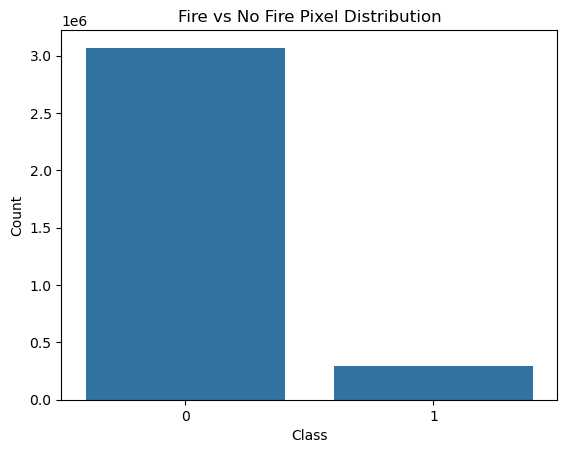

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution
unique, counts = np.unique(y_valid, return_counts=True)
class_dist = dict(zip(unique, counts))

print("Class distribution:")
for label, count in class_dist.items():
    print(f"Class {label} (fire = {label}): {count} samples")

# Plot it
sns.barplot(x=list(class_dist.keys()), y=list(class_dist.values()))
plt.title("Fire vs No Fire Pixel Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


There is class imbalance in test dataset based on fire and no fire pixed
Fire pixels = 9.6%
No-fire pixels = 90.4%